# Example of "wide and deep" architectures* implemented in Keras / Tensorflow 

* Cheng, H.-T., and Coauthors, 2016: Wide & Deep Learning for Recommender Systems. arXiv:1606.07792 [cs, stat],.

Taken from **Chapter 10** of 

[Geron, A., 2017: Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. 1st ed. O’Reilly Media, Inc.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

### imports 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
import sys
import pathlib

In [3]:
import numpy as np
import pandas as pd

In [4]:
import numpy as np
import pandas as pd

In [5]:
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
import tensorflow as tf
from tensorflow import keras

### check that the GPU is available 

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
np.random.seed(42)

In [9]:
tf.random.set_seed(42)

### fetch the California Housing dataset (regression task)

In [10]:
housing = fetch_california_housing()

### target is median house value 

In [11]:
housing.target_names

['MedHouseVal']

In [12]:
housing.target

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

### and the features are ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

In [13]:
housing.data.shape

(20640, 8)

In [14]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

### train test split 

In [15]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

### scale all features (Standard Scaler) as features are in very different units 

In [16]:
scaler = StandardScaler()

In [17]:
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### first build a simple sequential model using the Keras Sequential API 

In [18]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [19]:
# keras.utils.plot_model(model)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [22]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4875 - val_loss: 0.4656

In [23]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 792us/step - loss: 0.4212


### plot the history 

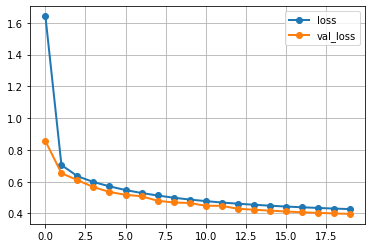

In [24]:
pd.DataFrame(history.history).plot(grid=True, lw=2, marker='o')

In [25]:
y_hat = model.predict(X_test)

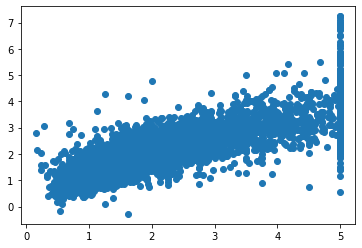

In [26]:
plt.scatter(y_test, y_hat.ravel())

In [27]:
np.corrcoef(y_hat.ravel(), y_test)

array([[1.        , 0.82569739],
       [0.82569739, 1.        ]])

### Now build a "Wide and Deep" architecture, using the functional API 

### the inputs will be goint through a 'deep' path (Dense layers) as well as being directly connected to the last layer (dense with one unit)

In [28]:
input_ = keras.layers.Input(shape=X_train.shape[1:])

hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_, hidden2])

output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_], outputs=[output])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           930         dense_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_3[0][0]                

In [30]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [31]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.8772 - val_loss: 0.6913
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6501 - val_loss: 0.9454
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6012 - val_loss: 0.6622
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5654 - val_loss: 0.5284
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5414 - val_loss: 0.5004
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5181 - val_loss: 0.5894
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5035 - val_loss: 0.5889
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4904 - val_loss: 0.4690
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4769 - val_loss: 0.5305
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4676 - val_loss: 0.5466

In [32]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 784us/step - loss: 0.4164


### plot the history 

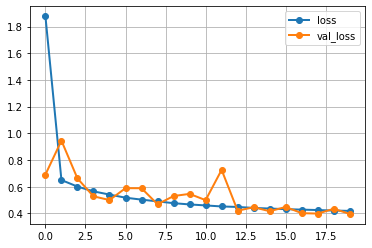

In [33]:
pd.DataFrame(history.history).plot(grid=True, lw=2, marker='o')

In [34]:
y_hat = model.predict(X_test)

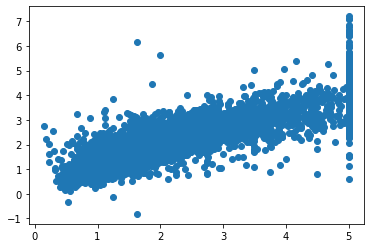

In [35]:
plt.scatter(y_test, y_hat.ravel())

In [36]:
np.corrcoef(y_hat.ravel(), y_test)

array([[1.        , 0.82786586],
       [0.82786586, 1.        ]])

### sending part of the features through the wide path, part through the deep path 

In this exemple, we will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [37]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])

output = keras.layers.Dense(1, name="output")(concat)

model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
____________________________________________________________________________________________

In [39]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [40]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [41]:
history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.0090 - val_loss: 0.9850
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7896 - val_loss: 0.7180
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6514 - val_loss: 0.6402
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5991 - val_loss: 0.5778
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5671 - val_loss: 0.5449
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5423 - val_loss: 0.5190
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5228 - val_loss: 0.5011
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5073 - val_loss: 0.4808
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4945 - val_loss: 0.4661
Epoch 10/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4841 - val_loss: 0.4553

In [42]:
mse_test = model.evaluate((X_test_A, X_test_B), y_test)

162/162 [==============================] - 0s 782us/step - loss: 0.4297


### plot the history 

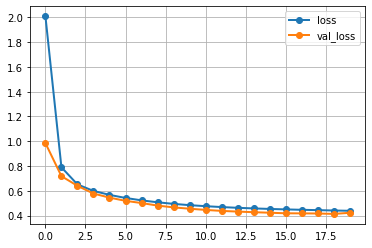

In [43]:
pd.DataFrame(history.history).plot(grid=True, lw=2, marker='o')

In [44]:
y_hat = model.predict((X_test_A, X_test_B))

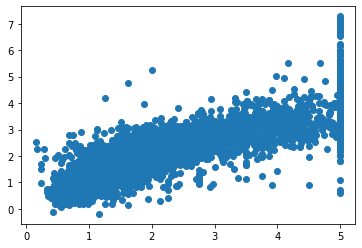

In [45]:
plt.scatter(y_test, y_hat.ravel())

In [46]:
np.corrcoef(y_hat.ravel(), y_test)

array([[1.        , 0.82177111],
       [0.82177111, 1.        ]])

### We can also add an auxiliary output for regularization 

In [47]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])

output = keras.layers.Dense(1, name="main_output")(concat)

aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [48]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           930         dense_7[0][0]                    
____________________________________________________________________________________________

In [49]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [50]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.2680 - main_output_loss: 1.9510 - aux_output_loss: 5.1214 - val_loss: 2.7346 - val_main_output_loss: 2.1457 - val_aux_output_loss: 8.0346
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 1.0709 - main_output_loss: 0.8465 - aux_output_loss: 3.0910 - val_loss: 1.5914 - val_main_output_loss: 0.8960 - val_aux_output_loss: 7.8500
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8526 - main_output_loss: 0.7034 - aux_output_loss: 2.1957 - val_loss: 1.2902 - val_main_output_loss: 0.6649 - val_aux_output_loss: 6.9176
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7558 - main_output_loss: 0.6404 - aux_output_loss: 1.7942 - val_loss: 1.1200 - val_main_output_loss: 0.6066 - val_aux_output_loss: 5.7407
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6982 - main_output_loss: 0.5992 - aux_output_loss: 1.5896 - val_loss

### plot the history 

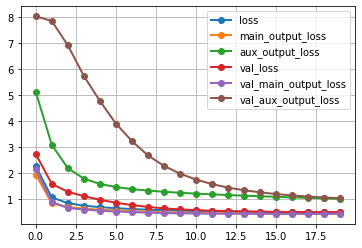

In [51]:
pd.DataFrame(history.history).plot(grid=True, lw=2, marker='o')

In [52]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.4880 - main_output_loss: 0.4318 - aux_output_loss: 0.9944


In [53]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

### Building a wide and deep model using the subclassing API 

In [54]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

In [55]:
model = WideAndDeepModel(30, activation="relu")

In [56]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [57]:
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.1210 - output_1_loss: 1.9986 - output_2_loss: 3.2225 - val_loss: 2.8539 - val_output_1_loss: 2.5208 - val_output_2_loss: 5.8515
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.9263 - output_1_loss: 0.7926 - output_2_loss: 2.1300 - val_loss: 1.5743 - val_output_1_loss: 1.2249 - val_output_2_loss: 4.7190
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7806 - output_1_loss: 0.6730 - output_2_loss: 1.7492 - val_loss: 1.1348 - val_output_1_loss: 0.8106 - val_output_2_loss: 4.0528
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7027 - output_1_loss: 0.6126 - output_2_loss: 1.5139 - val_loss: 0.9375 - val_output_1_loss: 0.6529 - val_output_2_loss: 3.4992
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6474 - output_1_loss: 0.5703 - output_2_loss: 1.3416 - val_loss: 0.7974 - val_output_1_loss: 0.5528 - val_ou

In [58]:
model.summary() # using the subclassing API, the summary can only be printed AFTER the model has been fitted 

Model: "wide_and_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              multiple                  210       
_________________________________________________________________
dense_10 (Dense)             multiple                  930       
_________________________________________________________________
dense_11 (Dense)             multiple                  36        
_________________________________________________________________
dense_12 (Dense)             multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


### plot the history 

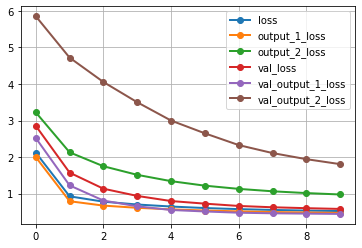

In [59]:
pd.DataFrame(history.history).plot(grid=True, lw=2, marker='o')

In [60]:
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))

162/162 [==============================] - 0s 1ms/step - loss: 0.5130 - output_1_loss: 0.4627 - output_2_loss: 0.9656


In [61]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

In [62]:
y_pred_main

array([[0.35760832],
       [1.5615234 ],
       [2.886736  ]], dtype=float32)

In [63]:
y_pred_aux

array([[0.9063777],
       [2.0154343],
       [2.4638891]], dtype=float32)

In [64]:
y_hat_main, y_hat_aux = model.predict((X_test_A, X_test_B))